In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import opensmile
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbpipeline
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
import seaborn as sns

def plot_cm(trues, preds, targets, title):
    # adapted from https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix


    all_voice_cm = confusion_matrix(trues, preds, labels=targets, normalize='true')

    all_voice_cm / all_voice_cm.astype(np.float).sum(axis=1)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(all_voice_cm, annot=True, fmt='.2f', xticklabels=targets, yticklabels=targets)
    plt.ylabel('Intended Emotion')
    plt.xlabel('Predicted emotion by model')
    plt.title(title)
    plt.show(block=False)

TARGET_NAMES = ["A", "D", "F", "H", "N", "S"]

In [2]:
voice_train = pd.read_pickle("./audio_tables/voice_train_split_df")
voice_test = pd.read_pickle("./audio_tables/voice_test_split_df")
voice_test_mismatch = pd.read_pickle("./combined_voice_votes_incorrect")

In [5]:
def extract_opensmile_features(voice_data):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    return smile.process_files(['./CREMA-D/AudioWAV/'+name+'.wav' for name in list(voice_data.fileName)])

def preprocess_audio_df(voice_data, labelencoder, scaler):
    voice_data_os = extract_opensmile_features(voice_data)
    
    voice_data_os.index = [i[0].split("/")[-1] for i in voice_data_os.index]
    voice_data_os["intendedEmo"] = list(voice_data.intendedEmo)
    
    voice_data_os["intendedEmo"] = labelencoder.fit_transform(voice_data_os["intendedEmo"])
    
    
    normalised_voice_data_os = voice_data_os.drop(columns=["intendedEmo"])
    normalised_voice_data_os.values[:] = scaler.fit_transform(voice_data_os.drop(columns=["intendedEmo"]))
    normalised_voice_data_os["intendedEmo"] = voice_data_os["intendedEmo"]
    return normalised_voice_data_os

In [3]:
standardised_voice_train_os = pd.read_pickle("./audio_tables/voice_train_os_clean_stand_df")

In [4]:
y_train = standardised_voice_train_os.intendedEmo
X_train = standardised_voice_train_os.drop(columns=["intendedEmo"])

In [5]:
pca = PCA(n_components=0.99, random_state=4)
pca.fit(X_train)
pca_data = pca.transform(X_train)
pca_data.shape

(2479, 1740)

In [7]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))

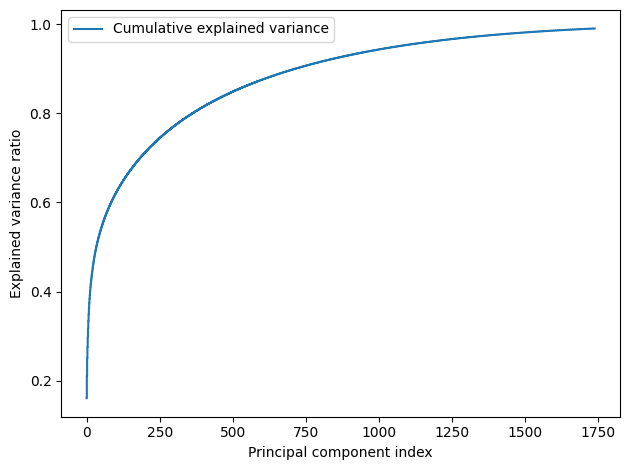

In [6]:
# from https://vitalflux.com/pca-explained-variance-concept-python-example/#:~:text=Explained%20variance%20is%20a%20statistical,component%20analysis%20(PCA)%20method.

exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [6]:
voice_train_X, voice_train_y = X_train, y_train

In [17]:
voice_train_y.value_counts()

4    832
0    616
2    326
1    274
3    264
5    167
Name: intendedEmo, dtype: int64

In [25]:
param_grid = {'classifier__C': [100, 0.001, 0.01, 0.1, 1 ,10], 
              'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
              'classifier__kernel': ['rbf']} 

# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
grid.fit(pca_data, voice_train_y)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 1/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.827) total time=  28.4s
[CV 2/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.778) total time=  26.0s
[CV 3/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.778) total time=  14.0s
[CV 4/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.738) total time=  17.5s
[CV 5/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.810) total time=  15.0s
[CV 6/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.823) total time=  14.2s
[CV 7/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.802) total time=

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=4)],
                                       ['classifier', SVC(random_state=4)]]),
             param_grid={'classifier__C': [100, 0.001, 0.01, 0.1, 1, 10],
                         'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'classifier__kernel': ['rbf']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [26]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('smote', SMOTE(random_state=4)),
                ['classifier', SVC(C=100, gamma=0.0001, random_state=4)]])

 The best score across ALL searched params:
 0.7930619041400025

 The best parameters across ALL searched params:
 {'classifier__C': 100, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}


In [27]:
pd.to_pickle(grid, "./grid_compare_clean_stand_pca_trainscores")

#### Plot GridSearchCV results using https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv

In [28]:
grid = pd.read_pickle("./grid_compare_clean_stand_pca_trainscores")

In [8]:
df = pd.DataFrame(grid.cv_results_)
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__C', 'param_classifier__gamma',
       'param_classifier__kernel', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

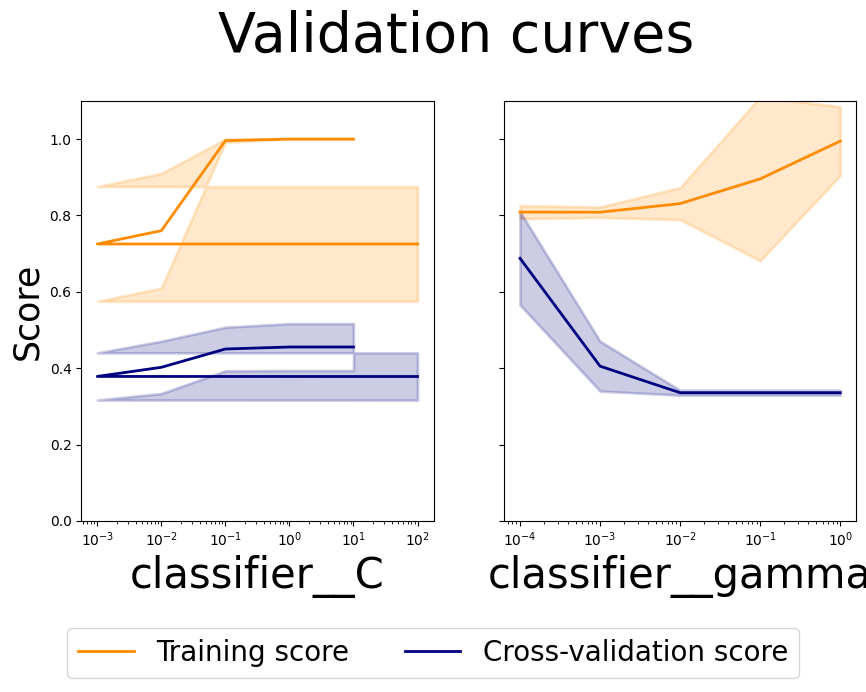

In [29]:
grid_params = {'classifier__C': [100, 0.001, 0.01, 0.1, 1 ,10], 
              'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
              } 


df = pd.DataFrame(grid.cv_results_)
results = ['mean_test_score',
           'mean_train_score',
           'std_test_score', 
           'std_train_score']

# Following is from https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv
# https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
def pooled_var(stds):
    n = 5 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))


fig, axes = plt.subplots(1, len(grid_params), 
                         figsize = (5*len(grid_params), 7),
                         sharey='row')
axes[0].set_ylabel("Score", fontsize=25)
lw = 2

for idx, (param_name, param_range) in enumerate(grid_params.items()):
    grouped_df = df.groupby(f'param_{param_name}')[results]\
        .agg({'mean_train_score': 'mean',
              'mean_test_score': 'mean',
              'std_train_score': pooled_var,
              'std_test_score': pooled_var})

    previous_group = df.groupby(f'param_{param_name}')[results]
    axes[idx].set_xlabel(param_name, fontsize=30)
    axes[idx].set_ylim(0.0, 1.1)
    axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                color="darkorange", lw=lw)
    axes[idx].fill_between(param_range, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                    grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                    color="darkorange", lw=lw)
    axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                color="navy", lw=lw)
    axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                    grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                    color="navy", lw=lw)
    axes[idx].set_xscale('log')

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=40)
fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

fig.subplots_adjust(bottom=0.25, top=0.85)  
plt.show()

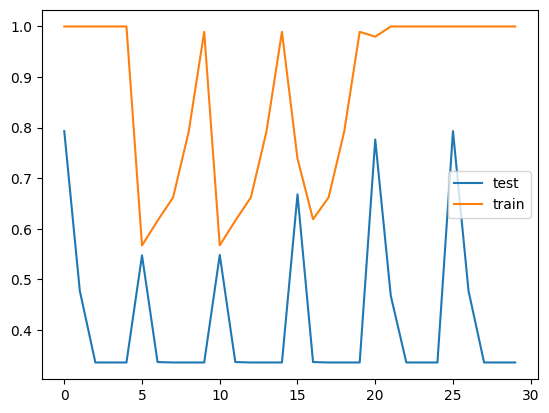

In [30]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

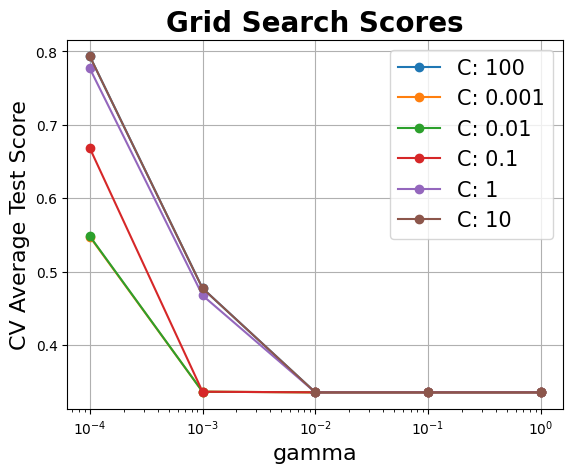

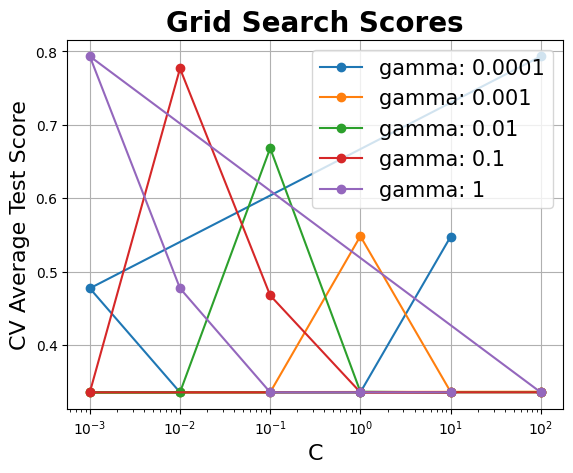

In [53]:
Cs = grid_params["classifier__C"]
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Function copied and adapted from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
    
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

#     scores_sd = cv_results['std_test_score']
#     scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Test Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    ax.set_xscale('log')

# Calling Method 
plot_grid_search(grid.cv_results_,  grid_params["classifier__gamma"],grid_params["classifier__C"], 'gamma', 'C')
plot_grid_search(grid.cv_results_,  grid_params["classifier__C"], grid_params["classifier__gamma"], 'C', 'gamma')

In [36]:
pca_test_match = pca.transform(X_test_match)

In [50]:
# defining parameter range
param_grid = {'classifier__C': [100,1000], 
              'classifier__gamma': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001],
              'classifier__kernel': ['rbf']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid2 = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
# fitting the model for grid search
grid2.fit(pca_data, voice_train_y)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END classifier__C=100, classifier__gamma=1e-07, classifier__kernel=rbf;, score=(train=0.790, test=0.738) total time=  14.5s
[CV 2/10] END classifier__C=100, classifier__gamma=1e-07, classifier__kernel=rbf;, score=(train=0.795, test=0.669) total time=  30.5s
[CV 3/10] END classifier__C=100, classifier__gamma=1e-07, classifier__kernel=rbf;, score=(train=0.780, test=0.746) total time=  29.4s
[CV 4/10] END classifier__C=100, classifier__gamma=1e-07, classifier__kernel=rbf;, score=(train=0.792, test=0.649) total time=  26.4s
[CV 5/10] END classifier__C=100, classifier__gamma=1e-07, classifier__kernel=rbf;, score=(train=0.786, test=0.738) total time=  28.3s
[CV 6/10] END classifier__C=100, classifier__gamma=1e-07, classifier__kernel=rbf;, score=(train=0.775, test=0.754) total time=  29.0s
[CV 7/10] END classifier__C=100, classifier__gamma=1e-07, classifier__kernel=rbf;, score=(train=0.785, test=0.690) total time=  24.4s

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=4)],
                                       ['classifier', SVC(random_state=4)]]),
             param_grid={'classifier__C': [100, 1000],
                         'classifier__gamma': [1e-07, 1e-06, 1e-05, 0.0001,
                                               0.001],
                         'classifier__kernel': ['rbf']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [51]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid2.best_estimator_)
print("\n The best score across ALL searched params:\n",grid2.best_score_)
print("\n The best parameters across ALL searched params:\n",grid2.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('smote', SMOTE(random_state=4)),
                ['classifier', SVC(C=100, gamma=0.0001, random_state=4)]])

 The best score across ALL searched params:
 0.7930619041400025

 The best parameters across ALL searched params:
 {'classifier__C': 100, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}


## Standardise

In [8]:
labelencoder = pd.read_pickle("label_encoder.pkl")
standard_scaler = StandardScaler()
standardised_voice_test_os = preprocess_audio_df(voice_test, labelencoder, standard_scaler)

In [10]:
pd.to_pickle(standardised_voice_test_os, "./audio_tables/voice_test_os_clean_stand_df")

In [17]:
standardised_voice_test_os = pd.read_pickle("./audio_tables/voice_test_os_clean_stand_df")

y_test_match = standardised_voice_test_os.intendedEmo
X_test_match = standardised_voice_test_os.drop(columns=["intendedEmo"])

In [16]:
%%time
best_svm_clean_pca = SVC(C=100, gamma=0.0001, random_state=4, kernel="rbf").fit(pca_data, voice_train_y)
pca_test_match = pca.transform(X_test_match)

CPU times: user 6.07 s, sys: 72.9 ms, total: 6.14 s
Wall time: 5.77 s


In [21]:
%%time
y_pred_match = best_svm_clean_pca.predict(pca_test_match)

CPU times: user 2.61 s, sys: 0 ns, total: 2.61 s
Wall time: 2.61 s


In [15]:
accuracy = accuracy_score(y_test_match,y_pred_match)*100
confusion_mat = confusion_matrix(y_test_match,y_pred_match)

# Printing the results
print("Accuracy for SVM is:",accuracy)
print("Confusion Matrix")
print(confusion_mat)

Accuracy for SVM is: 80.48387096774194
Confusion Matrix
[[136   7   5   5   1   0]
 [  5  46   5   2  10   1]
 [  7   5  56   4   5   4]
 [ 13   3   3  42   5   0]
 [  1   4   1   5 197   0]
 [  1   5   3   0  11  22]]


In [19]:
standardised_voice_test_mismatch = preprocess_audio_df(voice_test_mismatch, labelencoder, standard_scaler)
pd.to_pickle(standardised_voice_test_mismatch, "./audio_tables/voice_test_mismatch_clean_stand_df")

In [22]:
standardised_voice_test_mismatch = pd.read_pickle("./audio_tables/voice_test_mismatch_clean_stand_df")

In [23]:
y_test_mismatch = standardised_voice_test_mismatch.intendedEmo
X_test_mismatch = standardised_voice_test_mismatch.drop(columns=["intendedEmo"])

In [12]:
%%time
pca_test_mismatch = pca.transform(X_test_mismatch)

CPU times: user 3 s, sys: 85 ms, total: 3.08 s
Wall time: 865 ms


In [17]:
%%time
y_pred_mismatch = best_svm_clean_pca.predict(pca_test_mismatch)

CPU times: user 18.1 s, sys: 293 ms, total: 18.4 s
Wall time: 18.1 s


In [18]:
mismatch_accuracy = accuracy_score(y_test_mismatch,y_pred_mismatch)*100
mismatch_confusion_mat = confusion_matrix(y_test_mismatch,y_pred_mismatch)

# Printing the results
print("Accuracy for SVM on mismatched and ambiguous data is:",mismatch_accuracy)
print("Confusion Matrix")
print(mismatch_confusion_mat)

Accuracy for SVM on mismatched and ambiguous data is: 33.36403407782639
Confusion Matrix
[[424  23  12  16  26   0]
 [242 316  44  35 252  39]
 [161  62 226  41 283  91]
 [394  42  76 274 153   2]
 [ 11   0   3   0  33   0]
 [ 41  92 118  12 623 176]]


In [23]:
labelencoder = pd.read_pickle("label_encoder.pkl")

mismatch_trues = labelencoder.inverse_transform(y_test_mismatch)
mismatch_preds = labelencoder.inverse_transform(y_pred_mismatch)

match_trues = labelencoder.inverse_transform(y_test_match)
match_preds = labelencoder.inverse_transform(y_pred_match)

In [25]:
match_test_res = pd.DataFrame({
    "preds": match_preds,
    "trues": match_trues
})
pd.to_pickle(match_test_res, "./test_results/pca_audio_matching_results_df")

In [26]:
mismatch_test_res = pd.DataFrame({
    "preds": mismatch_preds,
    "trues": mismatch_trues
})
pd.to_pickle(mismatch_test_res, "./test_results/pca_audio_mismatching_results_df")

/tmp/ipykernel_3517879/4120909841.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_voice_cm / all_voice_cm.astype(np.float).sum(axis=1)


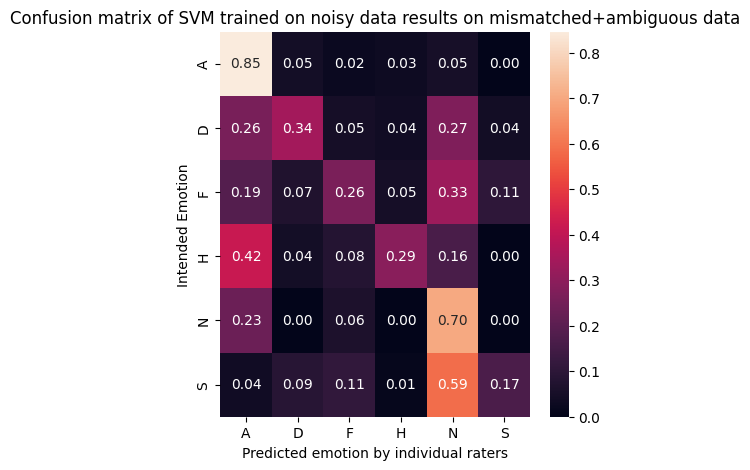

In [27]:
# mismatch_trues = labelencoder.inverse_transform(y_test_mismatch)
# mismatch_preds = labelencoder.inverse_transform(y_pred_mismatch)

plot_cm(mismatch_trues, mismatch_preds, TARGET_NAMES, "Confusion matrix of SVM trained on noisy data results on mismatched+ambiguous data")

/tmp/ipykernel_3517879/4120909841.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_voice_cm / all_voice_cm.astype(np.float).sum(axis=1)


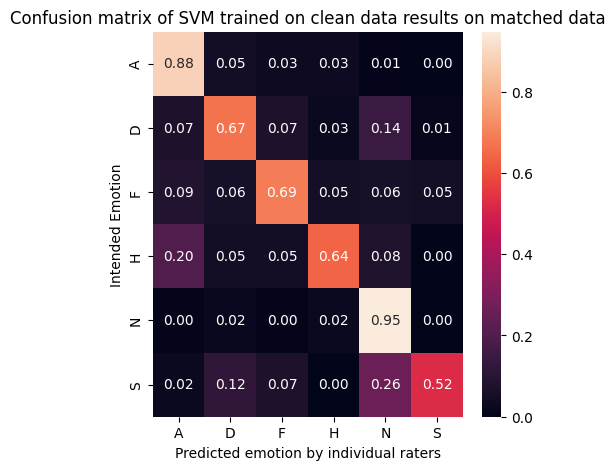

In [28]:
plot_cm(match_trues, match_preds, TARGET_NAMES, "Confusion matrix of SVM trained on clean data results on matched data")

## PCA 90% variability

In [7]:
pca_90 = PCA(n_components=0.90, random_state=4)
pca_90.fit(X_train)
pca_90_data = pca_90.transform(X_train)
pca_90_data.shape

(2479, 717)

In [46]:
%%time
# defining parameter range
param_grid = {'classifier__C': [100, 0.001, 0.01, 0.1, 1 ,10], 
              'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
              'classifier__kernel': ['rbf']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid_90 = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
grid_90.fit(pca_90_data, voice_train_y)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 1/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.831) total time=   3.6s
[CV 2/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.774) total time=   3.5s
[CV 3/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.786) total time=   3.6s
[CV 4/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.762) total time=   3.5s
[CV 5/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.819) total time=   3.6s
[CV 6/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.827) total time=   3.7s
[CV 7/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.806) total time=

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=4)],
                                       ['classifier', SVC(random_state=4)]]),
             param_grid={'classifier__C': [100, 0.001, 0.01, 0.1, 1, 10],
                         'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'classifier__kernel': ['rbf']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [47]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_90.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_90.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_90.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('smote', SMOTE(random_state=4)),
                ['classifier', SVC(C=100, gamma=0.0001, random_state=4)]])

 The best score across ALL searched params:
 0.7999183753428235

 The best parameters across ALL searched params:
 {'classifier__C': 100, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}


In [32]:
%%time
best_svm_clean_pca_90 = SVC(C=100, gamma=0.0001, random_state=4, kernel="rbf").fit(pca_90_data, voice_train_y)
pca_90_test_match = pca_90.transform(X_test_match)

CPU times: user 2.13 s, sys: 4.89 ms, total: 2.13 s
Wall time: 1.97 s


In [33]:
%%time
y_pred_match_90 = best_svm_clean_pca_90.predict(pca_90_test_match)

CPU times: user 742 ms, sys: 3.4 ms, total: 746 ms
Wall time: 742 ms


In [34]:
accuracy_90 = accuracy_score(y_test_match,y_pred_match_90)*100
confusion_mat_90 = confusion_matrix(y_test_match,y_pred_match_90)

# Printing the results
print("Accuracy for SVM is:",accuracy_90)
print("Confusion Matrix")
print(confusion_mat_90)

Accuracy for SVM is: 80.96774193548387
Confusion Matrix
[[138   6   4   6   0   0]
 [  6  46   5   2   9   1]
 [  7   4  57   4   5   4]
 [ 13   3   4  42   4   0]
 [  2   3   1   6 194   2]
 [  1   6   2   0   8  25]]


In [35]:
%%time
pca_90_test_mismatch = pca_90.transform(X_test_mismatch)

CPU times: user 1.23 s, sys: 88.1 ms, total: 1.31 s
Wall time: 408 ms


In [36]:
%%time
y_pred_mismatch_90 = best_svm_clean_pca_90.predict(pca_90_test_mismatch)

CPU times: user 5.36 s, sys: 285 ms, total: 5.65 s
Wall time: 5.33 s


In [37]:
mismatch_accuracy_90 = accuracy_score(y_test_mismatch,y_pred_mismatch_90)*100
mismatch_confusion_mat_90 = confusion_matrix(y_test_mismatch,y_pred_mismatch_90)

# Printing the results
print("Accuracy for SVM on mismatched and ambiguous data is:",mismatch_accuracy_90)
print("Confusion Matrix")
print(mismatch_confusion_mat_90)

Accuracy for SVM on mismatched and ambiguous data is: 34.262030854248216
Confusion Matrix
[[420  28  13  18  22   0]
 [245 332  49  34 232  36]
 [163  70 241  37 264  89]
 [389  45  80 281 142   4]
 [  9   2   2   0  34   0]
 [ 40 108 122  12 600 180]]


## PCA 90% Variability (larger grid search)

In [13]:
%%time
# defining parameter range
param_grid = {'classifier__C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 
              'classifier__gamma': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
              'classifier__kernel': ['rbf']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid_90 = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
grid_90.fit(pca_90_data, voice_train_y)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV 1/10] END classifier__C=1e-05, classifier__gamma=1e-05, classifier__kernel=rbf;, score=(train=0.407, test=0.468) total time=  10.0s
[CV 2/10] END classifier__C=1e-05, classifier__gamma=1e-05, classifier__kernel=rbf;, score=(train=0.395, test=0.343) total time=  10.0s
[CV 3/10] END classifier__C=1e-05, classifier__gamma=1e-05, classifier__kernel=rbf;, score=(train=0.405, test=0.395) total time=  10.0s
[CV 4/10] END classifier__C=1e-05, classifier__gamma=1e-05, classifier__kernel=rbf;, score=(train=0.431, test=0.387) total time=  10.0s
[CV 5/10] END classifier__C=1e-05, classifier__gamma=1e-05, classifier__kernel=rbf;, score=(train=0.414, test=0.403) total time=  10.0s
[CV 6/10] END classifier__C=1e-05, classifier__gamma=1e-05, classifier__kernel=rbf;, score=(train=0.394, test=0.415) total time=  10.0s
[CV 7/10] END classifier__C=1e-05, classifier__gamma=1e-05, classifier__kernel=rbf;, score=(train=0.402, test=0.391) tota

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=4)],
                                       ['classifier', SVC(random_state=4)]]),
             param_grid={'classifier__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0,
                                           10.0, 100.0, 1000.0],
                         'classifier__gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1,
                                               1.0, 10.0, 100.0, 1000.0],
                         'classifier__kernel': ['rbf']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [14]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_90.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_90.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_90.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('smote', SMOTE(random_state=4)),
                ['classifier', SVC(C=10.0, gamma=0.0001, random_state=4)]])

 The best score across ALL searched params:
 0.7999183753428235

 The best parameters across ALL searched params:
 {'classifier__C': 10.0, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}


In [15]:
pd.to_pickle(grid_90, "./grid_compare_clean_stand_pca90_trainscores")

In [27]:
%%time
best_svm_clean_pca_90 = SVC(C=100, gamma=0.0001, random_state=4, kernel="rbf").fit(pca_90_data, voice_train_y)
pca_90_test_match = pca_90.transform(X_test_match)

CPU times: user 1.93 s, sys: 36 ms, total: 1.97 s
Wall time: 1.82 s


In [28]:
%%time
y_pred_match_90 = best_svm_clean_pca_90.predict(pca_90_test_match)

CPU times: user 627 ms, sys: 7.99 ms, total: 635 ms
Wall time: 633 ms


In [29]:
accuracy_90 = accuracy_score(y_test_match,y_pred_match_90)*100
confusion_mat_90 = confusion_matrix(y_test_match,y_pred_match_90)

# Printing the results
print("Accuracy for SVM is:",accuracy_90)
print("Confusion Matrix")
print(confusion_mat_90)

Accuracy for SVM is: 80.96774193548387
Confusion Matrix
[[138   6   4   6   0   0]
 [  6  46   5   2   9   1]
 [  7   4  57   4   5   4]
 [ 13   3   4  42   4   0]
 [  2   3   1   6 194   2]
 [  1   6   2   0   8  25]]


In [30]:
%%time
pca_90_test_mismatch = pca_90.transform(X_test_mismatch)

CPU times: user 1.07 s, sys: 100 ms, total: 1.17 s
Wall time: 365 ms


In [31]:
%%time
y_pred_mismatch_90 = best_svm_clean_pca_90.predict(pca_90_test_mismatch)

CPU times: user 4.54 s, sys: 1.47 ms, total: 4.54 s
Wall time: 4.54 s


In [32]:
mismatch_accuracy_90 = accuracy_score(y_test_mismatch,y_pred_mismatch_90)*100
mismatch_confusion_mat_90 = confusion_matrix(y_test_mismatch,y_pred_mismatch_90)

# Printing the results
print("Accuracy for SVM on mismatched and ambiguous data is:",mismatch_accuracy_90)
print("Confusion Matrix")
print(mismatch_confusion_mat_90)

Accuracy for SVM on mismatched and ambiguous data is: 34.262030854248216
Confusion Matrix
[[420  28  13  18  22   0]
 [245 332  49  34 232  36]
 [163  70 241  37 264  89]
 [389  45  80 281 142   4]
 [  9   2   2   0  34   0]
 [ 40 108 122  12 600 180]]


In [34]:
labelencoder = pd.read_pickle("label_encoder.pkl")

mismatch_trues = labelencoder.inverse_transform(y_test_mismatch)
mismatch_preds_90 = labelencoder.inverse_transform(y_pred_mismatch_90)

match_trues = labelencoder.inverse_transform(y_test_match)
match_preds_90 = labelencoder.inverse_transform(y_pred_match_90)

In [35]:
match_test_res = pd.DataFrame({
    "preds": match_preds_90,
    "trues": match_trues
})
pd.to_pickle(match_test_res, "./test_results/pca90_audio_matching_results_df")

mismatch_test_res = pd.DataFrame({
    "preds": mismatch_preds_90,
    "trues": mismatch_trues
})
pd.to_pickle(mismatch_test_res, "./test_results/pca90_audio_mismatching_results_df")

In [5]:
match_test_res = pd.read_pickle("./test_results/pca90_audio_matching_results_df")
mismatch_test_res = pd.read_pickle("./test_results/pca90_audio_mismatching_results_df")

match_trues = match_test_res.trues
match_preds_90 = match_test_res.preds

mismatch_trues = mismatch_test_res.trues
mismatch_preds_90 = mismatch_test_res.preds

/tmp/ipykernel_2665639/2546534669.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_voice_cm / all_voice_cm.astype(np.float).sum(axis=1)


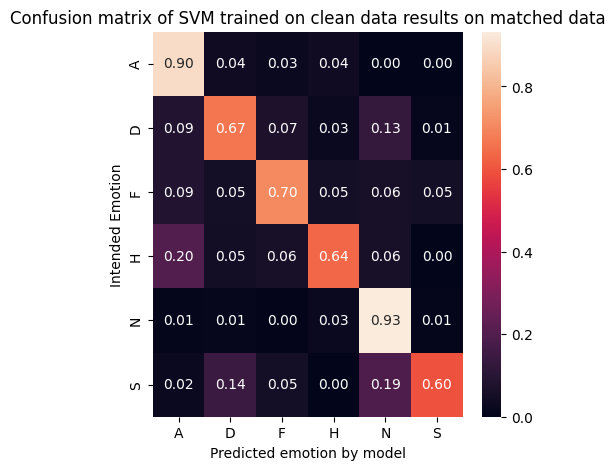

In [6]:
plot_cm(match_trues, match_preds_90, TARGET_NAMES, "Confusion matrix of SVM trained on clean data results on matched data")

/tmp/ipykernel_2665639/2546534669.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_voice_cm / all_voice_cm.astype(np.float).sum(axis=1)


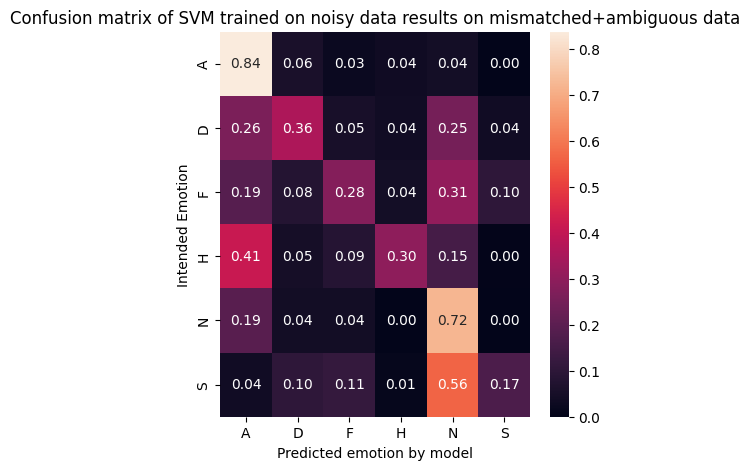

In [7]:
plot_cm(mismatch_trues, mismatch_preds_90, TARGET_NAMES, "Confusion matrix of SVM trained on noisy data results on mismatched+ambiguous data")

## PCA 80% Varaibility

In [38]:
pca_80 = PCA(n_components=0.80, random_state=4)
pca_80.fit(X_train)
pca_80_data = pca_80.transform(X_train)
pca_80_data.shape

(2479, 364)

In [48]:
%%time
# defining parameter range
param_grid = {'classifier__C': [100, 0.001, 0.01, 0.1, 1 ,10], 
              'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
              'classifier__kernel': ['rbf']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid_80 = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
grid_80.fit(pca_80_data, voice_train_y)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 1/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.806) total time=   1.9s
[CV 2/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.758) total time=   1.9s
[CV 3/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.778) total time=   1.9s
[CV 4/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.750) total time=   1.9s
[CV 5/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.815) total time=   1.9s
[CV 6/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.815) total time=   2.0s
[CV 7/10] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf;, score=(train=1.000, test=0.782) total time=

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=4)],
                                       ['classifier', SVC(random_state=4)]]),
             param_grid={'classifier__C': [100, 0.001, 0.01, 0.1, 1, 10],
                         'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'classifier__kernel': ['rbf']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [49]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_80.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_80.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_80.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('smote', SMOTE(random_state=4)),
                ['classifier', SVC(C=10, gamma=0.0001, random_state=4)]])

 The best score across ALL searched params:
 0.7845778372730834

 The best parameters across ALL searched params:
 {'classifier__C': 10, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}


In [39]:
%%time
best_svm_clean_pca_80 = SVC(C=100, gamma=0.0001, random_state=4, kernel="rbf").fit(pca_80_data, voice_train_y)
pca_80_test_match = pca_80.transform(X_test_match)

CPU times: user 1.07 s, sys: 11.1 ms, total: 1.08 s
Wall time: 985 ms


In [40]:
%%time
y_pred_match_80 = best_svm_clean_pca_80.predict(pca_80_test_match)

CPU times: user 413 ms, sys: 0 ns, total: 413 ms
Wall time: 410 ms


In [41]:
accuracy_80 = accuracy_score(y_test_match,y_pred_match_80)*100
confusion_mat_80 = confusion_matrix(y_test_match,y_pred_match_80)

# Printing the results
print("Accuracy for SVM is:",accuracy_80)
print("Confusion Matrix")
print(confusion_mat_80)

Accuracy for SVM is: 80.0
Confusion Matrix
[[140   6   4   4   0   0]
 [  5  45   6   2  10   1]
 [  6   5  57   6   4   3]
 [ 13   4   3  42   4   0]
 [  3   6   2   7 187   3]
 [  1   6   1   0   9  25]]


In [42]:
%%time
pca_80_test_mismatch = pca_80.transform(X_test_mismatch)

CPU times: user 714 ms, sys: 75.6 ms, total: 790 ms
Wall time: 275 ms


In [43]:
%%time
y_pred_mismatch_80 = best_svm_clean_pca_80.predict(pca_80_test_mismatch)

CPU times: user 2.71 s, sys: 0 ns, total: 2.71 s
Wall time: 2.71 s


In [44]:
mismatch_accuracy_80 = accuracy_score(y_test_mismatch,y_pred_mismatch_80)*100
mismatch_confusion_mat_80 = confusion_matrix(y_test_mismatch,y_pred_mismatch_80)

# Printing the results
print("Accuracy for SVM on mismatched and ambiguous data is:",mismatch_accuracy_80)
print("Confusion Matrix")
print(mismatch_confusion_mat_80)

Accuracy for SVM on mismatched and ambiguous data is: 34.56136311305549
Confusion Matrix
[[423  26  10  19  23   0]
 [249 332  45  38 225  39]
 [166  79 247  40 248  84]
 [385  58  82 288 125   3]
 [  8   1   2   0  36   0]
 [ 40 126 137  16 568 175]]
